In [77]:
!pip install yfinance

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

In [79]:
# 爬取證券交易所的股價資料
def fetch_stock_data_exchange(stock_code):
  stock = yf.Ticker(f"{stock_code}.TW")
  data = stock.history(period='max',interval='1d')
  return data

def SMA(data, period=5, column='Close'):
  return data[column].rolling(window=period).mean()

def RSI(data, period=5, column='Close'):
  delta = data[column].diff(1)
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=period).mean()
  avg_loss = loss.rolling(window=period).mean()
  RS = avg_gain.div(avg_loss)
  return RS.apply(lambda rs: 100 - (100 / (1+rs)))

def MACD(data, column='Close'):
  dif = data[column].ewm(span=12).mean() - data[column].ewm(span=26).mean()
  return dif.ewm(span=9).mean()

In [126]:
stock_code = '6139'  # 替換為實際的股號
data = fetch_stock_data_exchange(stock_code)
# data['date'] = pd.to_datetime(data['Date'])
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-08-25 00:00:00+08:00,19.896522,19.896522,18.597148,18.921988,1914209,0.0,0.0
2003-08-26 00:00:00+08:00,19.165615,19.490456,17.947460,18.191092,3817729,0.0,0.0
2003-08-27 00:00:00+08:00,18.678355,18.678355,17.541410,17.541410,2476990,0.0,0.0
2003-08-28 00:00:00+08:00,17.378990,17.622622,16.404469,16.648098,3575433,0.0,0.0
2003-08-29 00:00:00+08:00,16.648097,17.785040,16.242047,17.785040,3437350,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-24 00:00:00+08:00,236.500000,236.500000,226.000000,226.000000,3516310,0.0,0.0
2024-10-25 00:00:00+08:00,228.500000,231.500000,228.000000,230.000000,1597963,0.0,0.0
2024-10-28 00:00:00+08:00,230.000000,231.500000,224.500000,228.500000,1747306,0.0,0.0


In [81]:
data.index

DatetimeIndex(['2003-08-25 00:00:00+08:00', '2003-08-26 00:00:00+08:00',
               '2003-08-27 00:00:00+08:00', '2003-08-28 00:00:00+08:00',
               '2003-08-29 00:00:00+08:00', '2003-09-01 00:00:00+08:00',
               '2003-09-02 00:00:00+08:00', '2003-09-03 00:00:00+08:00',
               '2003-09-04 00:00:00+08:00', '2003-09-05 00:00:00+08:00',
               ...
               '2024-10-17 00:00:00+08:00', '2024-10-18 00:00:00+08:00',
               '2024-10-21 00:00:00+08:00', '2024-10-22 00:00:00+08:00',
               '2024-10-23 00:00:00+08:00', '2024-10-24 00:00:00+08:00',
               '2024-10-25 00:00:00+08:00', '2024-10-28 00:00:00+08:00',
               '2024-10-29 00:00:00+08:00', '2024-10-30 00:00:00+08:00'],
              dtype='datetime64[ns, Asia/Taipei]', name='Date', length=5235, freq=None)

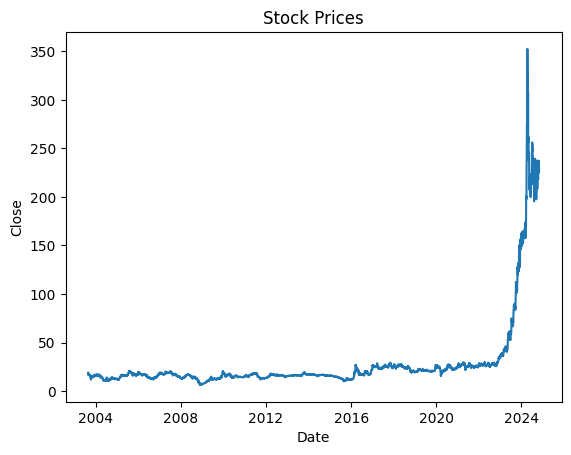

In [82]:
plt.plot(data.index,data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Stock Prices")
plt.show()

In [83]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

4974


In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

(4914, 60)


In [117]:
train_data

array([[0.03640639],
       [0.03429455],
       [0.03241736],
       ...,
       [0.300882  ],
       [0.30640836],
       [0.29811879]])

In [108]:
x_train.shape

(4914, 60, 1)

In [122]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(60, 1)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])
model.summary()

model.compile(optimizer='adam',
			loss='mean_squared_error')

history = model.fit(x_train,
            y_train,
            epochs=10)

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 32)                  │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,985 (7.75 KB)

 Trainable params: 1,985 (7.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6004e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1396e-05
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5912e-05
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3519e-05
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9366e-05
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8170e-05
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4067e-05
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3363e-05
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3153e-05
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0257e-05


In [123]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
print(predictions.shape)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(261, 1)
MSE 272.1472041490889
RMSE 16.4968846801173


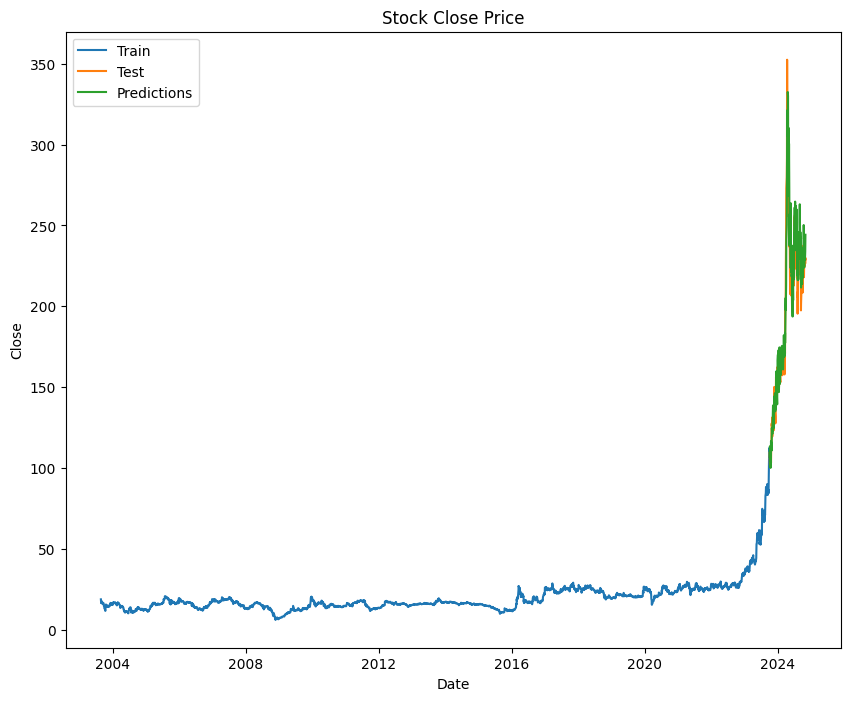

In [125]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train.index, train['Close'])
plt.plot(test.index, test[['Close', 'Predictions']])
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

# CNN


In [130]:
import pandas as pd
import numpy as np

# 假設 data 為包含時間、開盤價、最高價、最低價、收盤價的 DataFrame
data['5_MA'] = data['Close'].rolling(window=5).mean()  # 計算 5 日均線
data['10_MA'] = data['Close'].rolling(window=10).mean()  # 計算 10 日均線

# 標註漲跌 - 當5日均線高於10日均線時標註1（漲），否則標註0（跌）
data['Label'] = np.where(data['5_MA'] > data['10_MA'], 1, 0)

# 設定輸入特徵
N = 30  # 使用過去 N 天的 K 線數據
def create_features(data, N):
    X, y = [], []
    for i in range(N, len(data)):
        X.append(data[['Open', 'High', 'Low', 'Close']].values[i-N:i])  # 使用 N 天的 K 線圖數據
        y.append(data['Label'].values[i])  # 取標籤
    return np.array(X), np.array(y)

X, y = create_features(data, N)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 定義 CNN 模型
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(N, 4)),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 二元分類
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5023 - loss: 0.7694 - val_accuracy: 0.5744 - val_loss: 0.7383
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5085 - loss: 0.6945 - val_accuracy: 0.4707 - val_loss: 0.7513
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5210 - loss: 0.6921 - val_accuracy: 0.4256 - val_loss: 1.1204
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5267 - loss: 0.6916 - val_accuracy: 0.4256 - val_loss: 0.8699
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5105 - loss: 0.6951 - val_accuracy: 0.5869 - val_loss: 0.6903
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4997 - loss: 0.6941 - val_accuracy: 0.4544 - val_loss: 0.6932
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4803 - loss: 0.6929 - val_accuracy: 0.4256 - val_loss: 0.6937
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4773 - loss: 0.6933 - val_accuracy: 0

In [131]:
# 評估模型
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# 使用模型進行預測
predictions = (model.predict(X_test) > 0.5).astype("int32")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4560 - loss: 0.6948
Test Accuracy: 0.4879923164844513
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
